In [5]:
from nuscenes import NuScenes
from nuscenes.utils.data_classes import Box
from nuscenes.utils.geometry_utils import view_points
from PIL import Image
import numpy as np
import os
from tqdm import tqdm
import yaml
import cv2
import shutil
from pyquaternion import Quaternion


def print_category_stats(nusc):
    """Print statistics about annotation categories in the dataset"""
    categories = {}
    for sample in nusc.sample:
        for ann_token in sample["anns"]:
            ann = nusc.get("sample_annotation", ann_token)
            category = ann["category_name"]
            categories[category] = categories.get(category, 0) + 1

    print("\nCategory statistics:")
    for category, count in sorted(categories.items()):
        print(f"{category}: {count}")


def get_2d_bbox(nusc, sample_annotation, sample_data):
    """
    Get 2D bounding box from 3D annotation.
    Returns None if the box is not visible in the image.
    """
    box = Box(
        sample_annotation["translation"],
        sample_annotation["size"],
        Quaternion(sample_annotation["rotation"]),
        name=sample_annotation["category_name"],
    )

    # Get camera calibration data
    cam_data = nusc.get("sample_data", sample_data["token"])
    sensor = nusc.get("calibrated_sensor", cam_data["calibrated_sensor_token"])
    intrinsic = np.array(sensor["camera_intrinsic"])

    # Transform 3D box to sensor coordinates
    box.translate(-np.array(sensor["translation"]))
    box.rotate(Quaternion(sensor["rotation"]).inverse)

    # Project 3D box to 2D
    corners_3d = box.corners()
    corners_2d = view_points(corners_3d, intrinsic, normalize=True)[:2, :]

    # Check if box is behind camera
    if np.any(corners_3d[2, :] < 0):
        return None

    # Get 2D bounding box
    x_min, y_min = np.min(corners_2d, axis=1)
    x_max, y_max = np.max(corners_2d, axis=1)

    # Get image dimensions
    img_path = os.path.join(nusc.dataroot, cam_data["filename"])
    img = Image.open(img_path)
    img_width, img_height = img.size

    # Check if box is within image bounds
    if x_min < 0 or x_max >= img_width or y_min < 0 or y_max >= img_height:
        return None

    # Convert to YOLO format
    x_center = (x_min + x_max) / (2 * img_width)
    y_center = (y_min + y_max) / (2 * img_height)
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height

    return [x_center, y_center, width, height]


def create_yolo_dataset(nusc, split_ratio=0.8, output_dir="cone_dataset"):
    """
    Extract traffic cone data from nuScenes and prepare it for YOLO format.
    """
    print("Starting dataset creation...")
    print("\nAnalyzing dataset categories...")
    print_category_stats(nusc)

    # Create directory structure
    for subset in ["train", "val"]:
        for subdir in ["images", "labels"]:
            path = os.path.join(output_dir, subset, subdir)
            os.makedirs(path, exist_ok=True)

    total_scenes = len(nusc.scene)
    total_images_with_cones = 0
    processed_images = 0
    cone_data = []

    print("\nProcessing scenes...")

    for scene_idx, scene in enumerate(nusc.scene):
        print(f"\nProcessing scene {scene_idx + 1}/{total_scenes}")
        sample_token = scene["first_sample_token"]

        while sample_token:
            sample = nusc.get("sample", sample_token)
            cam_front_token = sample["data"]["CAM_FRONT"]
            cam_front_data = nusc.get("sample_data", cam_front_token)

            # Get all annotations for this sample
            annotations = []
            for ann_token in sample["anns"]:
                ann = nusc.get("sample_annotation", ann_token)
                # Debug print for first few annotations
                if processed_images < 1:
                    print(f"Debug - Annotation category: {ann['category_name']}")
                annotations.append(ann)

            # Filter for traffic cones (check for both possible category names)
            cone_annotations = [
                ann
                for ann in annotations
                if (
                    "traffic.cone" in ann["category_name"]
                    or "traffic_cone" in ann["category_name"]
                    or "cone" in ann["category_name"].lower()
                )
            ]

            if cone_annotations:
                print(f"Found {len(cone_annotations)} cones in image")
                img_path = os.path.join(nusc.dataroot, cam_front_data["filename"])
                if not os.path.exists(img_path):
                    print(f"Warning: Image not found at {img_path}")
                    continue

                valid_boxes = []
                for ann in cone_annotations:
                    bbox = get_2d_bbox(nusc, ann, cam_front_data)
                    if bbox is not None:
                        valid_boxes.append(bbox)

                if valid_boxes:
                    cone_data.append({"image_path": img_path, "boxes": valid_boxes})
                    total_images_with_cones += 1

            processed_images += 1
            if processed_images % 100 == 0:
                print(
                    f"Processed {processed_images} images, found {total_images_with_cones} with cones"
                )

            sample_token = sample["next"]

    print(f"\nTotal images processed: {processed_images}")
    print(f"Total images with cones: {total_images_with_cones}")

    if not cone_data:
        print("No traffic cones found in the dataset!")
        return

    # Split and save data
    np.random.shuffle(cone_data)
    split_idx = int(len(cone_data) * split_ratio)
    train_data = cone_data[:split_idx]
    val_data = cone_data[split_idx:]

    print(f"\nSplitting dataset: {len(train_data)} train, {len(val_data)} val")

    for subset, data in [("train", train_data), ("val", val_data)]:
        print(f"\nProcessing {subset} set...")
        for idx, item in enumerate(data):
            src_path = item["image_path"]
            dst_path = os.path.join(output_dir, subset, "images", f"{idx:06d}.jpg")
            shutil.copy2(src_path, dst_path)

            label_path = os.path.join(output_dir, subset, "labels", f"{idx:06d}.txt")
            with open(label_path, "w") as f:
                for box in item["boxes"]:
                    f.write(f"0 {' '.join(map(str, box))}\n")

    yaml_path = os.path.join(output_dir, "dataset.yaml")
    dataset_config = {
        "path": os.path.abspath(output_dir),
        "train": "train/images",
        "val": "val/images",
        "names": {0: "traffic_cone"},
    }

    with open(yaml_path, "w") as f:
        yaml.dump(dataset_config, f, sort_keys=False)

    print(f"\nDataset creation completed!")

In [6]:
dataroot = "../data/v1.0-mini"  # Replace with your NuScenes data path
nusc = NuScenes(version="v1.0-mini", dataroot=dataroot, verbose=True)
create_yolo_dataset(nusc)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.394 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Starting dataset creation...

Analyzing dataset categories...

Category statistics:
human.pedestrian.adult: 4765
human.pedestrian.child: 46
human.pedestrian.construction_worker: 193
human.pedestrian.personal_mobility: 25
human.pedestrian.police_officer: 11
movable_object.barrier: 2323
movable_object.debris: 13
movable_object.pushable_pullable: 82
movable_object.trafficcone: 1378
static_object.bicycle_rack: 54
vehicle.bicycle: 243
vehicle.bus.bendy: 57
vehicle.bus.rigid: 353
vehicle.car: 7619
vehicle.construction: 196
vehicle.motorcycle: 471
vehicle.trailer: 60
vehicle.truck: 649

Processing scenes...

Processing scene 1/10
Debug - Annotation category: human.pedestrian.

In [7]:
from ultralytics import YOLO
import torch
import os
import cv2
from PIL import Image
import numpy as np
import seaborn as sns
import seaborn.objects as so

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import matplotlib.pyplot as plt


class TrafficConeDetector:
    def __init__(self, dataset_yaml, weights_path=None):
        """
        Initialize the traffic cone detector
        Args:
            dataset_yaml: Path to dataset.yaml file
            weights_path: Path to pretrained weights (optional)
        """
        self.dataset_yaml = dataset_yaml
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Initialize model
        if weights_path and os.path.exists(weights_path):
            self.model = YOLO(weights_path)
            print(f"Loaded weights from {weights_path}")
        else:
            self.model = YOLO("yolov8n.pt")  # Start with pretrained YOLOv8n model
            print("Starting with pretrained YOLOv8n model")

    def train(self, epochs=100, imgsz=640, batch_size=16):
        """
        Train the model on the custom dataset
        """
        print(f"Training on {self.device} for {epochs} epochs...")

        # Training arguments
        args = dict(
            data=self.dataset_yaml,
            epochs=epochs,
            imgsz=imgsz,
            batch=batch_size,
            patience=20,  # Early stopping patience
            save=True,  # Save checkpoints
            device=self.device,
            plots=True,  # Save training plots
            verbose=True,
        )

        # Start training
        results = self.model.train(**args)
        print("Training completed!")
        return results

    def validate(self):
        """
        Validate the model on the validation set
        """
        print("Running validation...")
        results = self.model.val(data=self.dataset_yaml)
        return results

    def predict(self, image_path, conf_threshold=0.25):
        """
        Detect traffic cones in a single image
        Args:
            image_path: Path to the image
            conf_threshold: Confidence threshold for detections
        Returns:
            Annotated image and detections
        """
        results = self.model.predict(source=image_path, conf=conf_threshold, save=False)
        return results[0]

    def process_video(self, video_path, output_path, conf_threshold=0.25):
        """
        Process a video file and detect traffic cones
        Args:
            video_path: Path to input video
            output_path: Path to save output video
            conf_threshold: Confidence threshold for detections
        """
        cap = cv2.VideoCapture(video_path)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))

        # Initialize video writer
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Run detection
            results = self.model.predict(source=frame, conf=conf_threshold, save=False)

            # Get annotated frame
            annotated_frame = results[0].plot()

            # Write frame
            out.write(annotated_frame)

            frame_count += 1
            if frame_count % 100 == 0:
                print(f"Processed {frame_count} frames")

        cap.release()
        out.release()
        print(f"Video processing completed. Saved to {output_path}")


def visualize_dataset(dataset_path, num_samples=5):
    """
    Visualize random samples from the dataset with their annotations
    Args:
        dataset_path: Path to dataset directory
        num_samples: Number of samples to visualize
    """
    train_img_dir = os.path.join(dataset_path, "train", "images")
    train_label_dir = os.path.join(dataset_path, "train", "labels")

    # Get random samples
    img_files = os.listdir(train_img_dir)
    sample_files = np.random.choice(
        img_files, min(num_samples, len(img_files)), replace=False
    )

    for img_file in sample_files:
        # Load image
        img_path = os.path.join(train_img_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load labels
        label_path = os.path.join(train_label_dir, img_file.replace(".jpg", ".txt"))
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                labels = f.readlines()

            # Draw boxes
            h, w = img.shape[:2]
            for label in labels:
                class_id, x_center, y_center, width, height = map(
                    float, label.strip().split()
                )

                # Convert YOLO format to pixel coordinates
                x1 = int((x_center - width / 2) * w)
                y1 = int((y_center - height / 2) * h)
                x2 = int((x_center + width / 2) * w)
                y2 = int((y_center + height / 2) * h)

                # Draw rectangle
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Display image
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis("off")
        plt.show()

Visualizing dataset samples...


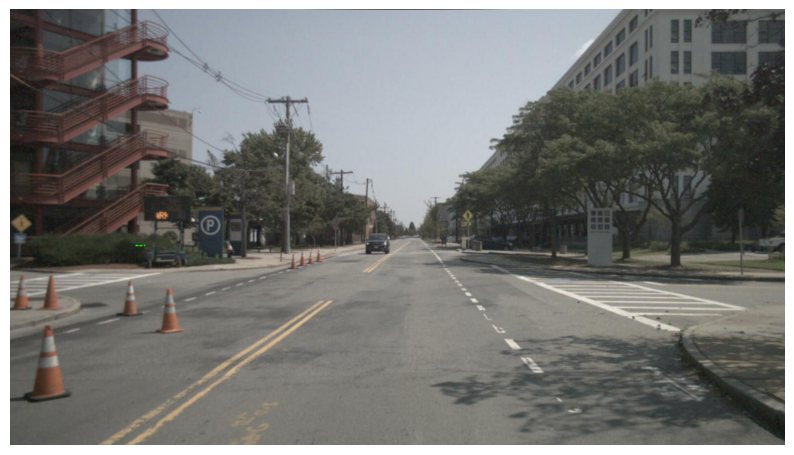

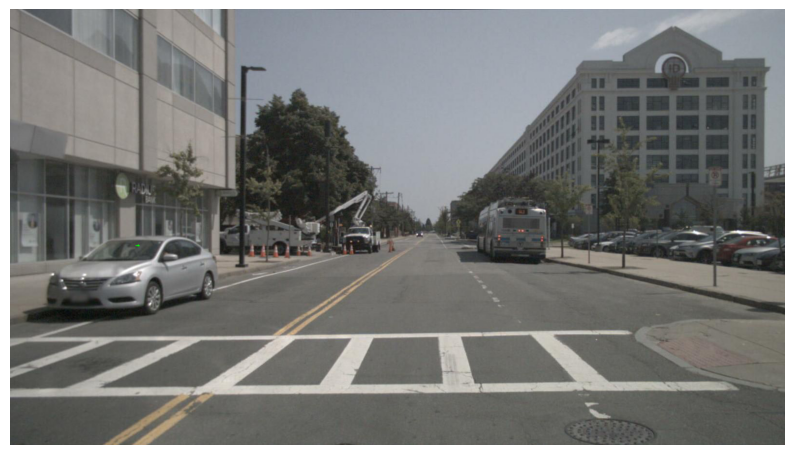

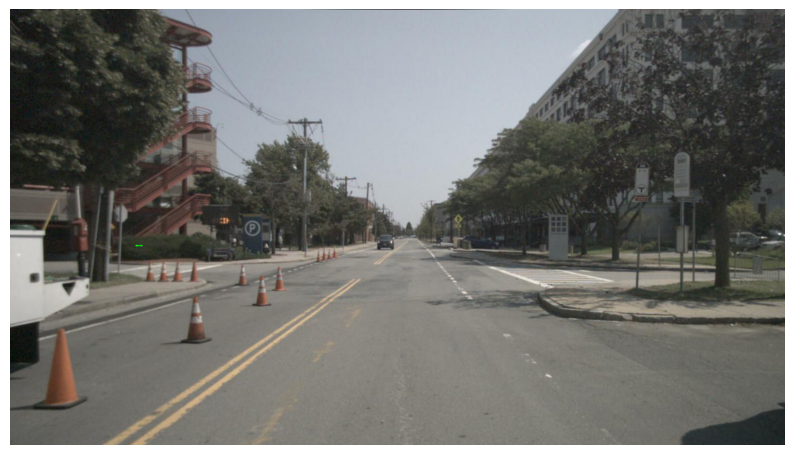

In [9]:
dataset_yaml = "cone_dataset/dataset.yaml"

print("Visualizing dataset samples...")
visualize_dataset("cone_dataset", num_samples=3)

In [10]:
# Initialize detector
detector = TrafficConeDetector(dataset_yaml)

# Train the model
results = detector.train(epochs=5)

Starting with pretrained YOLOv8n model
Training on cpu for 5 epochs...
New https://pypi.org/project/ultralytics/8.3.27 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.20 🚀 Python-3.11.5 torch-2.4.1 CPU (Apple M2 Max)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=cone_dataset/dataset.yaml, epochs=5, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retin

Fontconfig warning: ignoring UTF-8: not a valid region tag


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /Users/jiayizhou/Desktop/code_capstone/YOLONuScenes/code/cone_dataset/train/labels... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<00:00, 3335.37it/s]

train: New cache created: /Users/jiayizhou/Desktop/code_capstone/YOLONuScenes/code/cone_dataset/train/labels.cache



val: Scanning /Users/jiayizhou/Desktop/code_capstone/YOLONuScenes/code/cone_dataset/val/labels... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<00:00, 7033.49it/s]

val: New cache created: /Users/jiayizhou/Desktop/code_capstone/YOLONuScenes/code/cone_dataset/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2024/11/04 20:10:20 INFO mlflow.tracking.fluent: Experiment with name '/Shared/Ultralytics' does not exist. Creating a new experiment.
2024/11/04 20:10:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/11/04 20:10:22 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2024/11/04 20:10:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(b0c1925f91014b7ea603e3a0aa68a814) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G          0      79.29          0          0        640: 100%|██████████| 2/2 [00:07<00:00,  3.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all          6         40          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G          0      78.71          0          0        640: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all          6         40          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G          0      77.78          0          0        640: 100%|██████████| 2/2 [00:06<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all          6         40          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G          0      77.01          0          0        640: 100%|██████████| 2/2 [00:06<00:00,  3.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all          6         40          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G          0      76.51          0          0        640: 100%|██████████| 2/2 [00:07<00:00,  3.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all          6         40          0          0          0          0

5 epochs completed in 0.010 hours.


Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.20 🚀 Python-3.11.5 torch-2.4.1 CPU (Apple M2 Max)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all          6         40          0          0          0          0


Speed: 0.3ms preprocess, 27.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Training completed!


In [11]:
# Validate the model
val_results = detector.validate()

Running validation...
Ultralytics 8.3.20 🚀 Python-3.11.5 torch-2.4.1 CPU (Apple M2 Max)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/jiayizhou/Desktop/code_capstone/YOLONuScenes/code/cone_dataset/val/labels.cache... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all          6         40          0          0          0          0


Speed: 0.4ms preprocess, 30.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train2



image 1/1 /Users/jiayizhou/Desktop/code_capstone/YOLONuScenes/code/cone_dataset/val/images/000000.jpg: 384x640 (no detections), 53.0ms
Speed: 2.0ms preprocess, 53.0ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


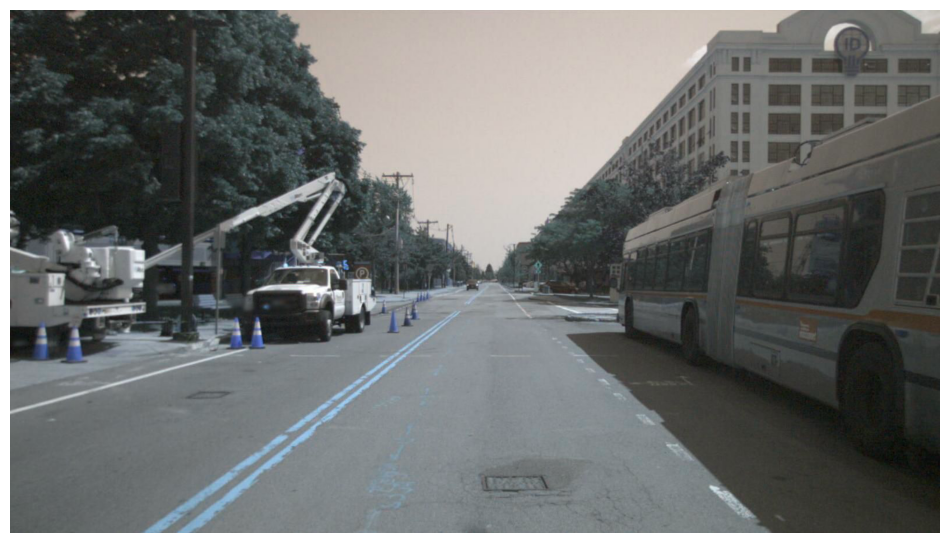

In [12]:
test_image = "cone_dataset/val/images/000000.jpg"

if os.path.exists(test_image):
    results = detector.predict(test_image)

    # Display results
    plt.figure(figsize=(12, 12))
    plt.imshow(results.plot())
    plt.axis("off")
    plt.show()